# Turtle Recall
A facial recognition model for turtles

https://zindi.africa/competitions/turtle-recall-conservation-challenge/data

# Imports

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tqdm
from PIL import Image

In [ ]:
print(f'TensorFlow version is {tf.__version__}')

TensorFlow version is 2.7.0


In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


# Dataset

First, we load the data. In addition to the turtles and images from the train.csv file, we also make use of extra_images.csv by concatenation with the train file. This yields substantially more (ca. 10.000) image files to later train the model on.

In [ ]:
IMAGE_DIR = './data/images'

In [ ]:
train = pd.read_csv("./data/train.csv")
extra_images = pd.read_csv("./data/extra_images.csv")

# Convert image_location strings to lowercase.
for row in [train]:
  row.image_location = row.image_location.apply(lambda x: x.lower())
  assert set(row.image_location.unique()) == set(['left', 'right', 'top'])

df = pd.concat(objs=[train, extra_images])

In [ ]:
images_per_turtle = pd.value_counts(df.turtle_id)
print(f'The total number of turtles is {len(df.turtle_id.unique())}.\n'
      'The mean number of training images per turtle is '
      f'{round(np.mean(images_per_turtle), 2)}, '
      f'and the median is {int(np.median(images_per_turtle))}.')

The total number of turtles is 2265.
The mean number of training images per turtle is 5.65, and the median is 3.


As we can see, however, we don't get a lot of images per turtle on average. Actually, some 2000 turtles are represented with less than 10 images in the dataset, which leads to a huge imbalance. Hence, we decide not to make use of any turtle with less than `MIN_NR_IMGS`.

In [ ]:
MIN_NR_IMGS = 10

im_per_turtle = images_per_turtle[images_per_turtle >= MIN_NR_IMGS].to_frame()
df = df[df.turtle_id.isin(im_per_turtle.index)].reset_index()

In [ ]:
images_per_turtle = pd.value_counts(df.turtle_id)
print(f'The total number of turtles after removal is {len(df.turtle_id.unique())}.\n'
      'The mean number of training images per turtle is now '
      f'{round(np.mean(images_per_turtle), 2)}, '
      f'and the median is {int(np.median(images_per_turtle))}. \n'
      f'The smallest number of images per turtle is '
      f'{min(df.turtle_id.value_counts())}.')

The total number of turtles after removal is 253.
The mean number of training images per turtle is now 19.72, and the median is 14. 
The smallest number of images per turtle is 10.


In [ ]:
print(df.shape)
df.head(3)

(4990, 4)


,index,image_id,image_location,turtle_id
0,0,ID_2RK4WLN8,top,t_id_VP2NW7aV
1,1,ID_VVW0QXLX,left,t_id_qZ0iZYsC
2,2,ID_RVATH2HZ,right,t_id_3b65X5Lw


We have now removed a significant portion of the data and are left with about 5000 images, which is still more than double the amount of the initial images in the `train.csv`. There is, however, still a huge imbalance in the dataset and the total number of files is quite small.

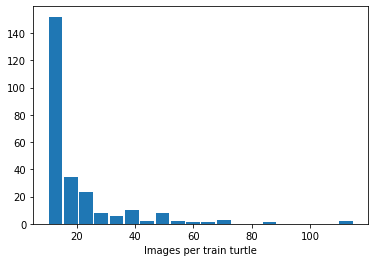

In [ ]:
plt.hist(x=images_per_turtle, rwidth=0.9, bins=20)
plt.xlabel('Images per train turtle')
plt.show()

# Preprocessing

Create three mappings and get the paths to the training set image files.
1. `labels` : turtle ID --> unique integer labels
1. `label_lookup` : unique integer labels --> turtle ID
1. `image_to_turtle` :  image IDs to turtle IDs (training set only).

In [ ]:
# required by current pipeline
turtle_ids = sorted(np.unique(df.turtle_id)) + ['new_turtle']

image_files = [os.path.join(IMAGE_DIR, f) for f in os.listdir(IMAGE_DIR) if f.split('.')[0] in df.image_id.values]
image_ids = [os.path.basename(f).split('.')[0] for f in image_files]

image_to_turtle = dict(zip(df.image_id, df.turtle_id))
labels = dict(zip(turtle_ids, np.arange(len(turtle_ids))))

loaded_labels = [labels[image_to_turtle[id]] for id in image_ids]

In [ ]:
# from tutorial.ipynb, but not currently used in pipeline
label_lookup = {v: k for k, v in labels.items()}
num_classes = len(labels)

image_turtle_ids = [image_to_turtle[id] for id in image_ids]

In [ ]:
NUM_CLASSES = len(turtle_ids)
NUM_CLASSES

254

In [ ]:
def crop_and_resize(pil_img, img_size=(224,224)):
  """Crop square from center of image and resize."""

  w, h = pil_img.size
  crop_size = min(w, h)
  crop = pil_img.crop(((w - crop_size) // 2, (h - crop_size) // 2,
                       (w + crop_size) // 2, (h + crop_size) // 2))
  
  return crop.resize(img_size)

tqdm.tqdm._instances.clear()
loaded_images = [crop_and_resize(Image.open(f)) for f in tqdm.tqdm(image_files)]

100%|██████████| 4990/4990 [01:48<00:00, 46.01it/s]


(224, 224)
4990


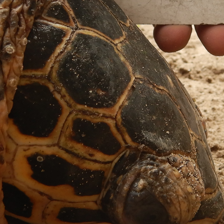

In [ ]:
# inspect an image
print(loaded_images[0].size)
print(len(loaded_images))
loaded_images[0]

In [ ]:
ims = tf.stack([tf.convert_to_tensor(np.asarray(im), dtype=tf.float32) for im in loaded_images])
labels = tf.stack(loaded_labels)

2022-04-05 15:09:05.306437: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-05 15:09:05.307807: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [ ]:
ds = tf.data.Dataset.from_tensor_slices((ims, labels))
ds = ds.map(lambda x,y: (x/255., tf.one_hot(y, NUM_CLASSES)))

print(f'The dataset contains {ds.cardinality().numpy()} images.')

The dataset contains 4990 images.


### Data augmentation
https://colab.research.google.com/github/tensorflow/addons/blob/master/docs/tutorials/image_ops.ipynb#scrollTo=tbaIkUCS2eNv

Before applying augmentation to our images and hence increasing the size of our training data, we shuffle the current dataset, take a few images and store them in a test set for eventually evaluating our model. We do this to preserve the real-world data we want our model to work on later. The augmentation is then only used on training and validation data to make sure our model learns with a variety of different images and is robust against noise, different colour and brightness values, etc.

In [ ]:
BUFFER = ds.cardinality().numpy()
TEST_SPLIT = 1500

ds = ds.shuffle(buffer_size=BUFFER, reshuffle_each_iteration=False)
test_ds, train_ds = ds.take(TEST_SPLIT), ds.skip(TEST_SPLIT)

print(f'Train images: {train_ds.cardinality().numpy()}', f'Test images: {test_ds.cardinality().numpy()}', sep='\n')

Train images: 3490
Test images: 1500


We implemented a bunch of augmentation functions to deal with the small dataset. After applying them, we further split off a validation part from the training images which we can use during the training process to assess the progress.

In [ ]:
# from functions.image_augmentation import rotate_images, apply_mean_filter, apply_gaussian_filter, random_hsv, add_noise

# ds_rotated = rotate_images(train_ds)
# ds_gaussian = apply_gaussian_filter(train_ds)
# ds_hsv = random_hsv(train_ds)
# ds_noise = add_noise(train_ds, 0.2)

# train_ds = train_ds.concatenate(ds_rotated).concatenate(ds_gaussian).concatenate(ds_hsv).concatenate(ds_noise)

In [ ]:
BATCH_SIZE = 32
TRAIN_SPLIT = np.round(train_ds.cardinality().numpy() * 0.9)

train_ds, val_ds = train_ds.take(TRAIN_SPLIT), train_ds.skip(TRAIN_SPLIT)

train_ds = train_ds.shuffle(512).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
train_ds = train_ds.cache(filename='cached_train_ds')

val_ds = val_ds.shuffle(256).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache(filename='cached_val_ds')

print(
    f'Training dataset contains {train_ds.cardinality().numpy() * BATCH_SIZE} images after data augmentation.',
    f'Validation dataset contains {val_ds.cardinality().numpy() * BATCH_SIZE} images.',
    sep='\n')

Training dataset contains 3136 images after data augmentation.
Validation dataset contains 320 images.


Below is an example of what an image with additive noise looks like. The general image and - most importantly - the shape of the pattern on the turtle's head are preserved, while the original image is altered in such a way that the neural network does not get to see the same image another time.

In [ ]:
%matplotlib inline

example = train_ds.take(1).map(lambda x,y: (x + tf.random.normal(x.shape, mean=0.0, stddev=0.2, dtype=tf.float32), y))
example = example.map(lambda x,y: (tf.clip_by_value(x, 0.0, 1.0), y))

for elem in example.take(1):
    im, label = elem
plt.imshow(im)
plt.show()

In [ ]:
#tf.keras.preprocessing.image.random_channel_shift
#tf.keras.preprocessing.image.random_brightness

# Training

In [ ]:
efficientNet = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224,224,3)),
    hub.KerasLayer("https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1", trainable=False),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])
efficientNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              4049564   
                                                                 
 dense (Dense)               (None, 254)               325374    
                                                                 
Total params: 4,374,938
Trainable params: 325,374
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
efficientNet.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

In [ ]:
efficientNet.fit(train_ds, epochs=10, validation_data=val_ds)

2022-04-05 15:14:47.827061: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 1/10


2022-04-05 15:14:54.013096: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-05 15:14:54.047860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - ETA: 0s - loss: 5.3739 - categorical_accuracy: 0.0322

2022-04-05 15:15:35.176769: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-04-05 15:15:36.538155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - 57s 454ms/step - loss: 5.3739 - categorical_accuracy: 0.0322 - val_loss: 5.1223 - val_categorical_accuracy: 0.0625


2022-04-05 15:15:46.557846: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-04-05 15:15:48.232461: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 2/10
98/98 [==============================] - ETA: 0s - loss: 4.5620 - categorical_accuracy: 0.1087

2022-04-05 15:16:35.082986: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-04-05 15:16:45.934784: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 4008 of 4990
2022-04-05 15:16:49.460828: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.
2022-04-05 15:16:50.263732: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 1 of 1024
2022-04-05 15:16:50.264471: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.


98/98 [==============================] - 74s 674ms/step - loss: 4.5620 - categorical_accuracy: 0.1087 - val_loss: 4.7831 - val_categorical_accuracy: 0.0719


2022-04-05 15:17:02.403550: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-04-05 15:17:04.332161: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 3/10
98/98 [==============================] - ETA: 0s - loss: 4.0345 - categorical_accuracy: 0.2009

2022-04-05 15:17:47.378488: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-04-05 15:17:58.304671: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 1 of 1024
2022-04-05 15:17:58.305824: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.


98/98 [==============================] - 60s 552ms/step - loss: 4.0345 - categorical_accuracy: 0.2009 - val_loss: 4.5348 - val_categorical_accuracy: 0.1187


2022-04-05 15:18:04.283560: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-04-05 15:18:05.912446: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 4/10
98/98 [==============================] - ETA: 0s - loss: 3.6061 - categorical_accuracy: 0.3010

2022-04-05 15:19:12.396655: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-04-05 15:19:22.774842: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 4539 of 4990
2022-04-05 15:19:25.329539: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.
2022-04-05 15:19:26.774869: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 1 of 1024
2022-04-05 15:19:26.775153: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.


98/98 [==============================] - 91s 858ms/step - loss: 3.6061 - categorical_accuracy: 0.3010 - val_loss: 4.3094 - val_categorical_accuracy: 0.1500


2022-04-05 15:19:37.170110: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-04-05 15:19:40.042741: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 5/10


2022-04-05 15:19:51.590136: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 3701 of 4990
2022-04-05 15:19:54.567013: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.
2022-04-05 15:19:54.974113: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 1 of 2048
2022-04-05 15:19:54.975919: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.


In [ ]:
efficientNet.evaluate(test_ds)